# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
import sys
sys.path.append("..")  # Adjust based on your directory structure

%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# %aimport afml

In [2]:
import warnings
import winsound
from datetime import timedelta, datetime as dt
from pprint import pprint
from pathlib import Path

import pandas_ta as ta
import talib
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import DropCorrelatedFeatures

from afml.backtest_statistics.reporting import (
    create_classification_report_image,
    meta_labelling_reports,
)

from afml.data_structures.bars import *
from afml.features import get_time_features, get_fractal_features
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    calculate_label_metrics,
    fixed_time_horizon,
    get_bins,
    get_bins_from_trend,
    get_events,
    triple_barrier_labels,
    get_trend_scanning_meta_labels,

)
from afml.strategies import (
    BaseStrategy,
    BollingerMeanReversionStrategy,
    MovingAverageCrossoverStrategy,
    TripleBarrierEvaluator,
    create_bollinger_features,
    get_entries,
)
from afml.util import (
    COMMODITIES,
    CLEAN_DATA_PATH,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    value_counts_data,
)
from afml.mt5.get_data import (
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
    verify_or_create_account_info,
)
from notebooks.training import train_meta_model, compare_roc_curves, meta_labelling_classification_reports

warnings.filterwarnings("ignore")
plt.style.use("dark_background")


In [3]:
# from afml.cache import clear_afml_cache


# clear_afml_cache()

## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = login_mt5(account="FundedNext_STLR2_6K")
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date


def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict[timeframe]
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
        except FileNotFoundError:
            save_data_to_parquet(CLEAN_DATA_PATH, symbol, start_date, end_date, account)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [5]:
timeframe = "M5"
tick_bar_size = tick_bar_dict[timeframe]
bb_time_bars, bb_tick_bars = get_data(symbol, timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"
bb_df0 = bb_time_bars.loc[sample_start : sample_end]
bb_df = bb_tick_bars.loc[sample_start : sample_end]

Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Feature Engineering

In [6]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerMeanReversionStrategy(window=bb_period, num_std=bb_std)

# No shifting b/c mean-reversion seems to benefit from contemporaneous information
lookback = 10
bb_feat = create_bollinger_features(bb_df, lookback, bb_period, bb_std)
bb_feat.info()

# trend_feat = get_bins_from_trend(bb_df.close, span=(5, bb_period), volatility_threshold=0.1, lookforward=False)
# bb_feat = bb_feat.join(trend_feat[['window', 'slope', 't_value', 'rsquared']])

# bb_feat = bb_feat.shift() # Avoid look-ahead bias


2025-08-31 03:42:58.820 | INFO     | afml.features.moving_averages:calculate_ma_differences:35 - 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427432 entries, 2018-01-01 23:53:43.270001 to 2021-12-31 22:54:42.047001
Data columns (total 48 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rel_spread        427432 non-null  float32
 1   bb_bandwidth      427413 non-null  float32
 2   bb_percentage     427413 non-null  float64
 3   returns           427431 non-null  float32
 4   returns_5         427427 non-null  float32
 5   returns_10        427422 non-null  float32
 6   returns_1_lag_1  

In [7]:
target_vol_params = dict(days=1, lookback=100)
tb_evaluator = TripleBarrierEvaluator(
    bb_strategy, bb_df, target_vol_params,
    target_vol_multiplier=1,
    filter_events=True,
    vertical_barrier_zero=True,
    on_crossover=True,
    )
pt_barrier, sl_barrier, time_horizon = (2, 1, 20)

2025-08-31 03:43:02.750 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-31 03:43:03.651 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 12,921 trade events generated by CUSUM filter.


### Fixed-Time Horizon Method

In [8]:
bb_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
bb_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_fh)

### Triple-Barrier Method

In [9]:
bb_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
bb_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_tbl)

In [10]:
print(f"Bollinger_w{bb_period}_std{bb_std}: \n")

bb_metrics_df = pd.DataFrame({
    "fixed_horizon": bb_events_fh_metrics,
    "triple_barrier": bb_events_tbl_metrics,
    })
bb_metrics_df

Bollinger_w20_std1.5: 



,fixed_horizon,triple_barrier
total_return,0.632238,0.506885
annualized_return,0.130591,0.108183
volatility,0.34303,0.325577
downside_volatility,0.229947,0.190051
sharpe_ratio,11.996695,10.589831
sortino_ratio,17.896434,18.141481
var_95,-0.001601,-0.001466
cvar_95,-0.002326,-0.001956
skewness,0.107378,0.316556
kurtosis,3.520836,1.951604


### Trend-Scanning Method

In [11]:
from afml.filters.filters import cusum_filter
from afml.labeling.trend_scanning import get_trend_scanning_meta_labels
from afml.util.volatility import get_daily_vol


span = (5, 20)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(bb_df.close).mean()
t_events = cusum_filter(bb_df.close, thres)
side = bb_strategy.generate_signals(bb_df)
close = bb_df.close

bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_metrics = calculate_label_metrics(bb_df.index, side, bb_events_trend)

bb_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
bb_events_trend_metrics_mr = calculate_label_metrics(bb_df.index, side, bb_events_trend_mr)

print(f"bb_events_trend.shape: {bb_events_trend.shape}, bb_events_trend_mr.shape: {bb_events_trend_mr.shape}\n")
print(f"Bollinger_w{bb_period}_std{bb_std}_trend_scanning: \n")
bb_events_trend_metrics_all = pd.concat([bb_events_trend_metrics, bb_events_trend_metrics_mr], axis=1)
bb_events_trend_metrics_all.columns = ["trend_time", "trend_time_mr"]
bb_events_trend_metrics_all

bb_events_trend.shape: (14777, 4), bb_events_trend_mr.shape: (14777, 4)

Bollinger_w20_std1.5_trend_scanning: 



,trend_time,trend_time_mr
total_return,0.770693,0.343075
annualized_return,0.153774,0.076636
volatility,0.334521,0.236554
downside_volatility,0.213756,0.19455
sharpe_ratio,12.527793,9.141699
sortino_ratio,19.605562,11.115425
var_95,-0.001577,-0.00106
cvar_95,-0.002235,-0.00178
skewness,0.048228,0.163776
kurtosis,2.700554,11.313642


### Random Forest

In [12]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )



Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1879
           1       0.51      1.00      0.68      1994

    accuracy                           0.51      3873
   macro avg       0.26      0.50      0.34      3873
weighted avg       0.27      0.51      0.35      3873


Confusion Matrix:
[[   0 1879]
 [   0 1994]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      1879
           1       0.52      0.41      0.46      1994

    accuracy                           0.51      3873
   macro avg       0.51      0.51      0.50      3873
weighted avg       0.51      0.51      0.50      3873


Confusion Matrix:
[[1137  742]
 [1174  820]]


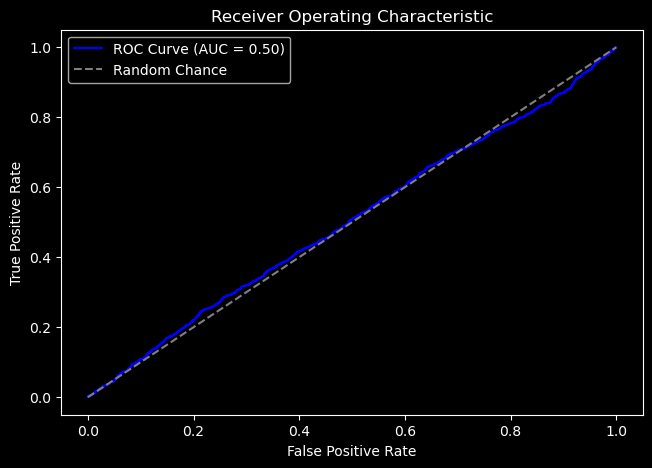

In [13]:
model_bb_fh = train_meta_model(model=rf, features=bb_feat, labels=bb_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_fh.y_test, model_bb_fh.w_test, model_bb_fh.pred, model_bb_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3740
           1       0.03      1.00      0.07       133

    accuracy                           0.03      3873
   macro avg       0.02      0.50      0.03      3873
weighted avg       0.00      0.03      0.00      3873


Confusion Matrix:
[[   0 3740]
 [   0  133]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      3740
           1       0.10      0.66      0.17       133

    accuracy                           0.78      3873
   macro avg       0.54      0.72      0.52      3873
weighted avg       0.95      0.78      0.85      3873


Confusion Matrix:
[[2931  809]
 [  45   88]]


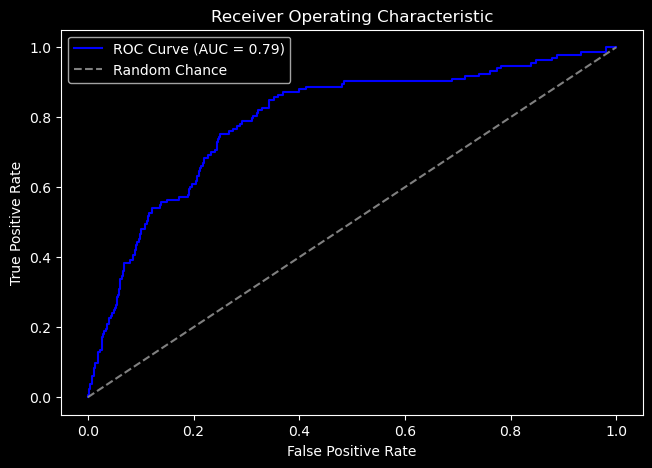

In [14]:
model_bb_tbl = train_meta_model(model=rf, features=bb_feat, labels=bb_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_tbl.y_test, model_bb_tbl.w_test, model_bb_tbl.pred, model_bb_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2379
           1       0.46      1.00      0.63      2050

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.21      0.46      0.29      4429


Confusion Matrix:
[[   0 2379]
 [   0 2050]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.73      0.33      0.45      2379
           1       0.52      0.85      0.65      2050

    accuracy                           0.57      4429
   macro avg       0.62      0.59      0.55      4429
weighted avg       0.63      0.57      0.55      4429


Confusion Matrix:
[[ 788 1591]
 [ 298 1752]]


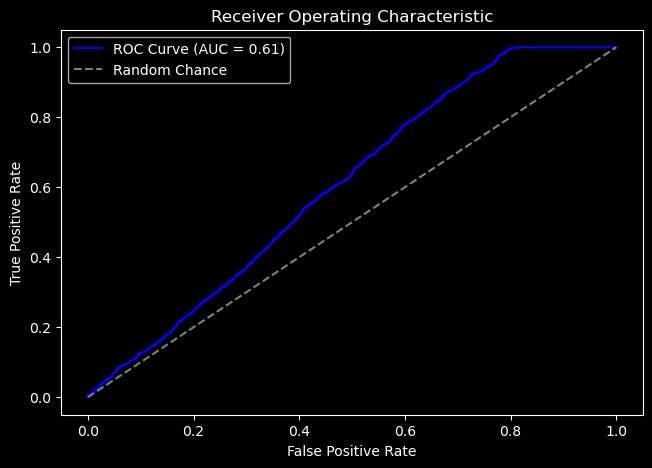

In [15]:
model_bb_trend = train_meta_model(model=rf, features=bb_feat, labels=bb_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend.y_test, model_bb_trend.w_test, model_bb_trend.pred, model_bb_trend.prob, plot_roc=True
    )

Trend-Scanning Mean-Reversion Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4129
           1       0.07      1.00      0.13       300

    accuracy                           0.07      4429
   macro avg       0.03      0.50      0.06      4429
weighted avg       0.00      0.07      0.01      4429


Confusion Matrix:
[[   0 4129]
 [   0  300]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90      4129
           1       0.28      1.00      0.43       300

    accuracy                           0.82      4429
   macro avg       0.64      0.90      0.66      4429
weighted avg       0.95      0.82      0.86      4429


Confusion Matrix:
[[3346  783]
 [   1  299]]


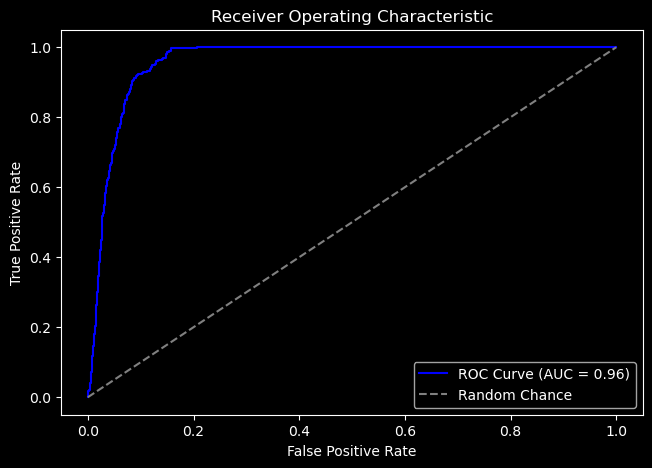

In [16]:
model_bb_trend_mr = train_meta_model(model=rf, features=bb_feat, labels=bb_events_trend_mr)
print("Trend-Scanning Mean-Reversion Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend_mr.y_test, model_bb_trend_mr.w_test, model_bb_trend_mr.pred, model_bb_trend_mr.prob, plot_roc=True
    )

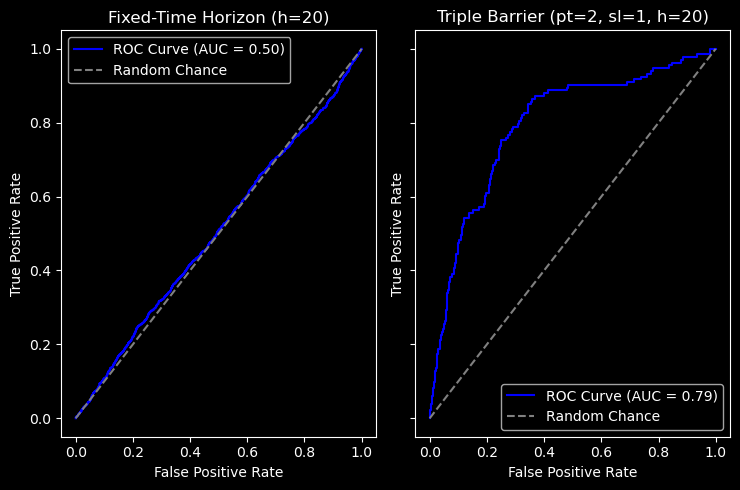

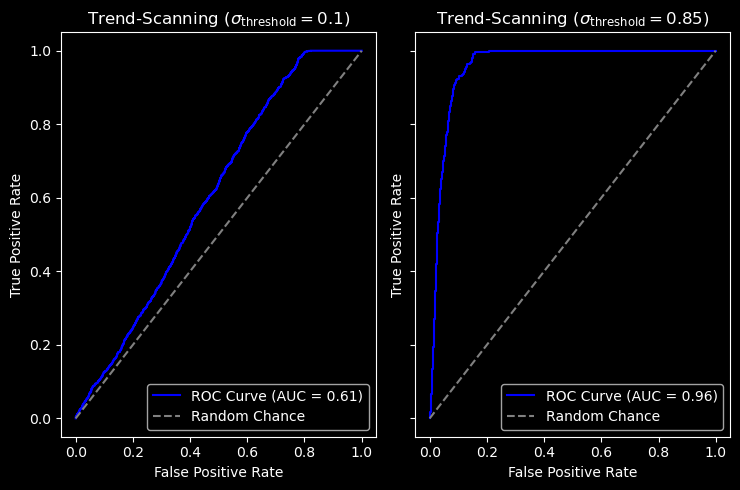

In [18]:
dirpath = "reports_tick_bars"
titles = [
    f"Fixed-Time Horizon (h={time_horizon})", 
    f"Triple Barrier (pt={pt_barrier}, sl={sl_barrier}, h={time_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
bb_models = [model_bb_fh, model_bb_tbl, model_bb_trend, model_bb_trend_mr]
bb_roc = compare_roc_curves(bb_models[:2], titles[:2])
bb_roc.savefig(f"{dirpath}/bb_roc_barrier_comparison.png")

bb_roc_trend = compare_roc_curves(bb_models[2:], titles[2:])
bb_roc_trend.savefig(f"{dirpath}/bb_roc_trend_comparison.png")

In [19]:
dirpath = "reports_tick_bars"
meta_labelling_classification_reports(model_data=model_bb_fh, title="Fixed-Time Horizon", output_filename=f"{dirpath}/bb_fixed_time")
meta_labelling_classification_reports(model_data=model_bb_tbl, title="Triple Barrier", output_filename=f"{dirpath}/bb_triple_barrier")
meta_labelling_classification_reports(model_data=model_bb_trend, title=f"Trend-Scanning (σ_threshold={volatility_threshold})", 
                                      output_filename=f"{dirpath}/bb_trend_scanning")
meta_labelling_classification_reports(model_data=model_bb_trend_mr, title=f"Trend-Scanning (σ_threshold={volatility_threshold_mr})", 
                                      output_filename=f"{dirpath}/bb_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1879
           1       0.51      1.00      0.68      1994

    accuracy                           0.51      3873
   macro avg       0.26      0.50      0.34      3873
weighted avg       0.27      0.51      0.35      3873


Confusion Matrix:
[[   0 1879]
 [   0 1994]]

Accuracy:
0.514846372321198

Successfully generated and saved 'reports_tick_bars/bb_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      1879
           1       0.52      0.41      0.46      1994

    accuracy                           0.51      3873
   macro avg       0.51      0.51      0.50      3873
weighted avg       0.51      0.51      0.50      3873


Confusion Matrix:
[[1137  742]
 [1174  820]]

Accuracy:
0.5052930544797315

Successfully generated and saved 'rep

## 3. Moving Average Crossover Strategy

In [20]:
ma_timeframe = "M30"
tick_bar_size = tick_bar_dict[ma_timeframe]
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"
ma_df0 = ma_time_bars.loc[sample_start : sample_end]
ma_df = ma_tick_bars.loc[sample_start : sample_end]

fast_window, slow_window = 20, 50
ma_strategy = MovingAverageCrossoverStrategy(fast_window, slow_window)
pt_barrier, sl_barrier, time_horizon = (3, 1, 100)
target_vol_params = dict(days=1, lookback=100)
vol_multiplier = 0.3
tb_evaluator = TripleBarrierEvaluator(
    ma_strategy, ma_df, target_vol_params,
    target_vol_multiplier=vol_multiplier,
    filter_events=True,
    vertical_barrier_zero=False,
    )

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq
2025-08-31 03:47:46.137 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-31 03:47:46.320 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 19,189 trade events generated by CUSUM filter.


### Feature Engineering

In [21]:
# from afml.features.fracdiff import fracdiff_optimal, frac_diff_ffd


# close_ffd, d, _ = fracdiff_optimal(ma_df.close, verbose=True)
# ma_df_ffd = frac_diff_ffd(ma_df, d)

In [22]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = feat_engine.calculate_all_features(ma_df)
ma_feat.info()

span = (5, slow_window)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

Memory usage reduced from 44.08 MB to 22.07 MB (49.9% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85486 entries, 2018-01-02 00:12:44.445001 to 2021-12-31 22:27:26.837001
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           85486 non-null  float32
 1   ma_20                           85486 non-null  float32
 2   ma_50                           85486 non-null  float32
 3   ma_100                          85486 non-null  float32
 4   ma_200                          85486 non-null  float32
 5   ma_10_20_cross                  85486 non-null  int8   
 6   ma_20_50_cross                  85486 non-null  int8   
 7   ma_50_200_cross                 85486 non-null  int8   
 8   ma_spread_10_20                 85486 non-null  float32
 9   ma_spread_20_50                 85486 non-null  float32
 10  ma_spread_50_200                85486 no

### Fixed-Time Horizon Method

In [23]:
ma_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
ma_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_fh)
ma_events_fh_metrics

2025-08-31 03:48:42.057 | INFO     | afml.labeling.performance_metrics:calculate_label_metrics:41 - Calculating avg_trade_duration using (events['t1'] - events.index).mean()


total_return                          -0.874566
annualized_return                     -0.405516
volatility                              0.66587
downside_volatility                    0.413436
sharpe_ratio                          -3.148168
sortino_ratio                         -5.070364
var_95                                -0.007487
cvar_95                               -0.009647
skewness                              -0.088534
kurtosis                               0.284268
probabilistic_sharpe_ratio             0.001432
pos_concentration                      0.000059
neg_concentration                       0.00006
time_concentration                     0.006001
max_drawdown                            0.89577
avg_drawdown                           0.195028
drawdown_duration             242 days 18:31:58
ulcer_index                            0.371927
calmar_ratio                          -0.452701
num_trades                                19145
trades_per_year                         

### Triple-Barrier Method

In [24]:
ma_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
ma_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_tbl)
ma_events_tbl_metrics

total_return                         -0.362787
annualized_return                    -0.106755
volatility                            0.266865
downside_volatility                   0.071106
sharpe_ratio                         -1.749276
sortino_ratio                        -6.565093
var_95                                -0.00185
cvar_95                              -0.002305
skewness                              1.073826
kurtosis                              0.207016
probabilistic_sharpe_ratio            0.049861
pos_concentration                     0.000027
neg_concentration                     0.000014
time_concentration                    0.005972
max_drawdown                          0.512168
avg_drawdown                          0.025299
drawdown_duration             44 days 04:46:24
ulcer_index                           0.093467
calmar_ratio                         -0.208438
num_trades                               19177
trades_per_year                           4801
win_rate     

In [25]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    })
ma_metrics_df

MACrossover_fast20_slow50: 



,fixed_horizon,triple_barrier
total_return,-0.874566,-0.362787
annualized_return,-0.405516,-0.106755
volatility,0.66587,0.266865
downside_volatility,0.413436,0.071106
sharpe_ratio,-3.148168,-1.749276
sortino_ratio,-5.070364,-6.565093
var_95,-0.007487,-0.00185
cvar_95,-0.009647,-0.002305
skewness,-0.088534,1.073826
kurtosis,0.284268,0.207016


### Trend-Scanning Method

In [26]:
span = (5, time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(ma_df.close).mean() * vol_multiplier
t_events = cusum_filter(ma_df.close, thres)
# _, t_events = get_entries(ma_strategy, ma_df)
print(f"t_events: {len(t_events):,}")

side = ma_strategy.generate_signals(ma_df)
close = ma_df.close

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_metrics = calculate_label_metrics(ma_df.index, side, ma_events_trend)

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

# ma_events_trend_ffd = get_trend_scanning_meta_labels(close_ffd, side, t_events, span, volatility_threshold, use_log=False)

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    "trend_scanning": ma_events_trend_metrics,
    "trend_scanning_mr": ma_events_trend_metrics_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

t_events: 19,198
2025-08-31 03:48:58.833 | INFO     | afml.labeling.performance_metrics:calculate_label_metrics:41 - Calculating avg_trade_duration using (events['t1'] - events.index).mean()
MACrossover_fast20_slow50:
ma_events_trend.shape: (19164, 4)



,fixed_horizon,triple_barrier,trend_scanning,trend_scanning_mr
total_return,-0.874566,-0.362787,-0.909642,-0.772707
annualized_return,-0.405516,-0.106755,-0.452185,-0.309878
volatility,0.66587,0.266865,0.691971,0.399571
downside_volatility,0.413436,0.071106,0.401023,0.338478
sharpe_ratio,-3.148168,-1.749276,-3.530741,-3.937807
sortino_ratio,-5.070364,-6.565093,-6.092351,-4.648558
var_95,-0.007487,-0.00185,-0.007668,-0.004659
cvar_95,-0.009647,-0.002305,-0.00984,-0.007511
skewness,-0.088534,1.073826,-0.067783,-0.251888
kurtosis,0.284268,0.207016,0.01056,7.407108


### Random Forest

In [27]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2938
           1       0.49      1.00      0.66      2805

    accuracy                           0.49      5743
   macro avg       0.24      0.50      0.33      5743
weighted avg       0.24      0.49      0.32      5743


Confusion Matrix:
[[   0 2938]
 [   0 2805]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      2938
           1       0.50      0.39      0.43      2805

    accuracy                           0.51      5743
   macro avg       0.51      0.51      0.50      5743
weighted avg       0.51      0.51      0.50      5743


Confusion Matrix:
[[1839 1099]
 [1724 1081]]


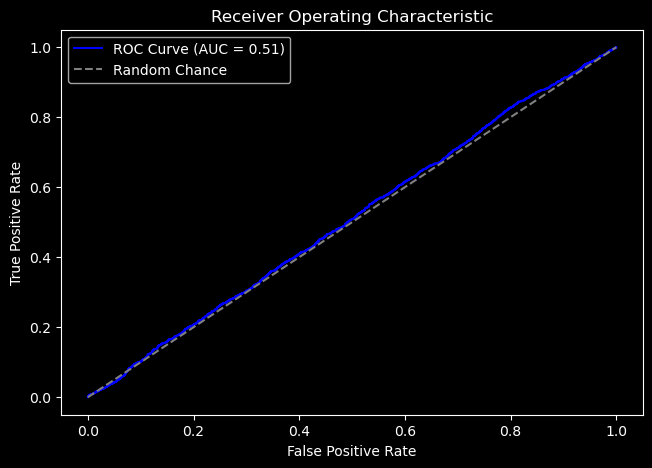

In [28]:
model_ma_fh = train_meta_model(model=rf, features=ma_feat, labels=ma_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_fh.y_test, model_ma_fh.w_test, model_ma_fh.pred, model_ma_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4115
           1       0.28      1.00      0.44      1638

    accuracy                           0.28      5753
   macro avg       0.14      0.50      0.22      5753
weighted avg       0.08      0.28      0.13      5753


Confusion Matrix:
[[   0 4115]
 [   0 1638]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      4115
           1       0.25      0.13      0.18      1638

    accuracy                           0.64      5753
   macro avg       0.48      0.49      0.47      5753
weighted avg       0.58      0.64      0.60      5753


Confusion Matrix:
[[3463  652]
 [1417  221]]


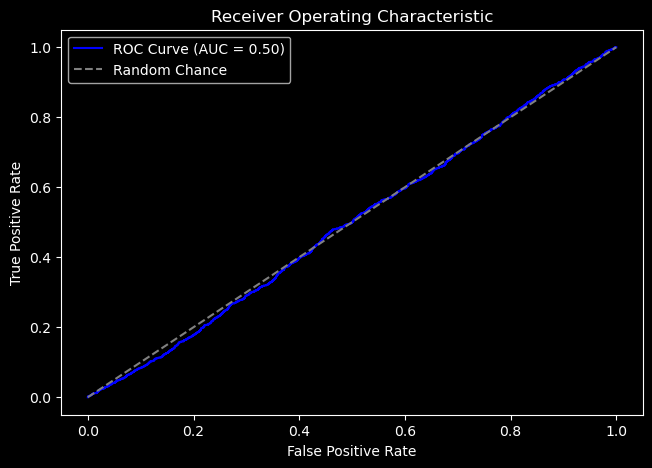

In [29]:
model_ma_tbl = train_meta_model(model=rf, features=ma_feat, labels=ma_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_tbl.y_test, model_ma_tbl.w_test, model_ma_tbl.pred, model_ma_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3167
           1       0.45      1.00      0.62      2582

    accuracy                           0.45      5749
   macro avg       0.22      0.50      0.31      5749
weighted avg       0.20      0.45      0.28      5749


Confusion Matrix:
[[   0 3167]
 [   0 2582]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.61      0.51      0.55      3167
           1       0.50      0.60      0.54      2582

    accuracy                           0.55      5749
   macro avg       0.55      0.55      0.55      5749
weighted avg       0.56      0.55      0.55      5749


Confusion Matrix:
[[1615 1552]
 [1044 1538]]


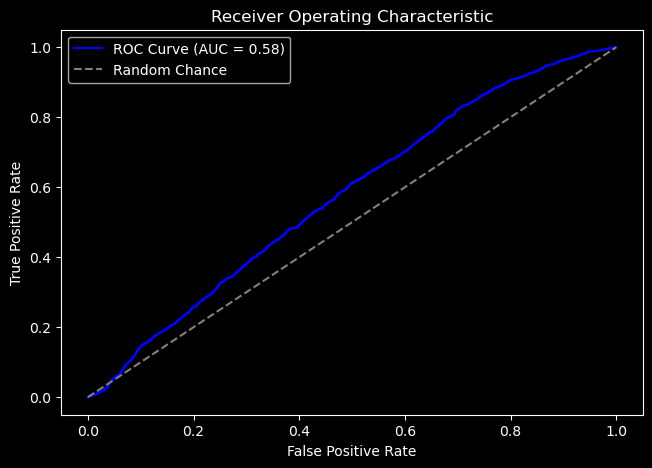

In [30]:
model_ma_trend = train_meta_model(model=rf, features=ma_feat, labels=ma_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend.y_test, model_ma_trend.w_test, model_ma_trend.pred, model_ma_trend.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5319
           1       0.07      1.00      0.14       430

    accuracy                           0.07      5749
   macro avg       0.04      0.50      0.07      5749
weighted avg       0.01      0.07      0.01      5749


Confusion Matrix:
[[   0 5319]
 [   0  430]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5319
           1       0.25      0.79      0.38       430

    accuracy                           0.81      5749
   macro avg       0.62      0.80      0.64      5749
weighted avg       0.93      0.81      0.85      5749


Confusion Matrix:
[[4326  993]
 [  91  339]]


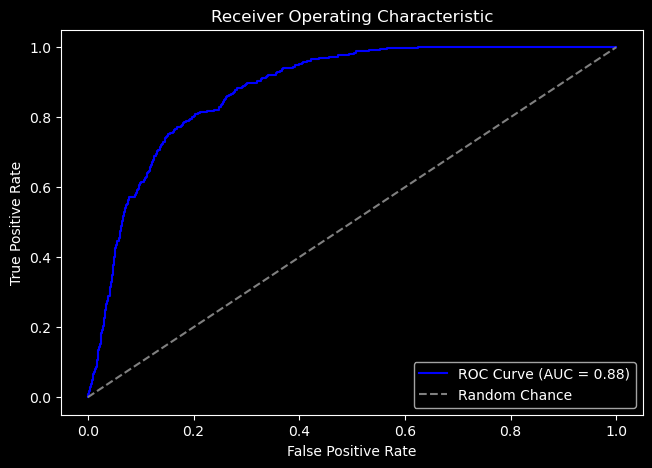

In [31]:
model_ma_trend_mr = train_meta_model(model=rf, features=ma_feat, labels=ma_events_trend_mr)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend_mr.y_test, model_ma_trend_mr.w_test, model_ma_trend_mr.pred, model_ma_trend_mr.prob, plot_roc=True
    )

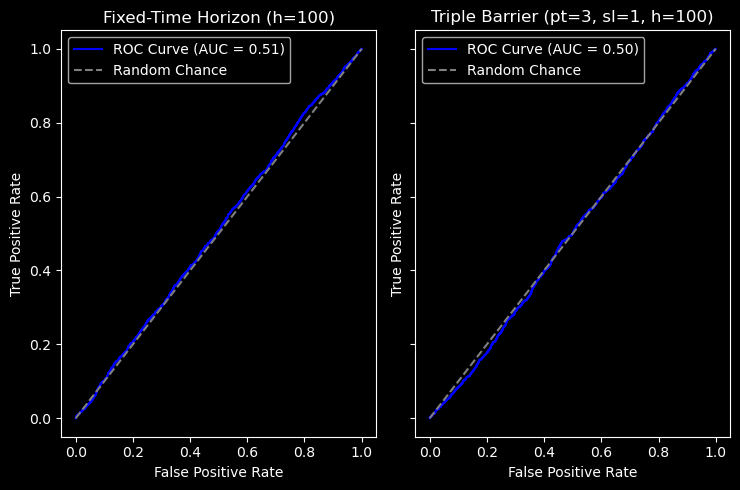

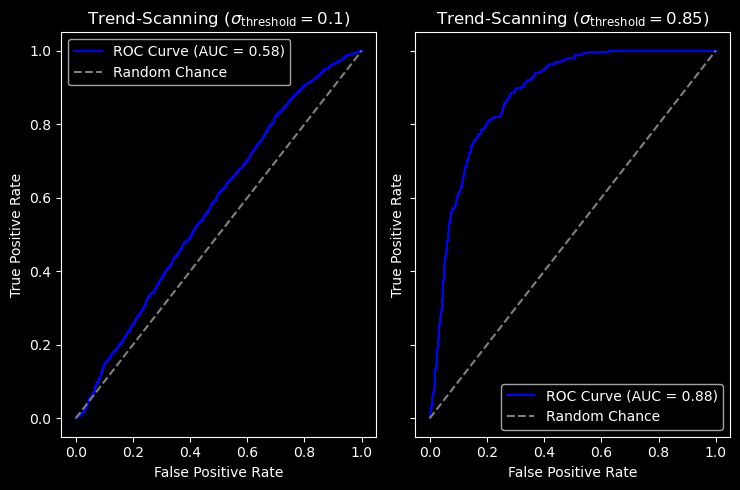

In [32]:
dirpath = "reports_tick_bars"
titles = [
    f"Fixed-Time Horizon (h={time_horizon})", 
    f"Triple Barrier (pt={pt_barrier}, sl={sl_barrier}, h={time_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh, model_ma_tbl, model_ma_trend, model_ma_trend_mr]
ma_roc = compare_roc_curves(ma_models[:2], titles[:2])
ma_roc.savefig(f"{dirpath}/ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(f"{dirpath}/ma_roc_trend_comparison.png")

In [33]:
dirpath = "reports_tick_bars"
meta_labelling_classification_reports(model_data=model_ma_fh, title="Fixed-Time Horizon", output_filename=f"{dirpath}/ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_tbl, title="Triple Barrier", output_filename=f"{dirpath}/ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_trend, title=f"Trend-Scanning (σ_threshold={volatility_threshold})", 
                                      output_filename=f"{dirpath}/ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_trend_mr, title=f"Trend-Scanning (σ_threshold={volatility_threshold_mr})", 
                                      output_filename=f"{dirpath}/ma_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2938
           1       0.49      1.00      0.66      2805

    accuracy                           0.49      5743
   macro avg       0.24      0.50      0.33      5743
weighted avg       0.24      0.49      0.32      5743


Confusion Matrix:
[[   0 2938]
 [   0 2805]]

Accuracy:
0.48842068605258576

Successfully generated and saved 'reports_tick_bars/ma_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      2938
           1       0.50      0.39      0.43      2805

    accuracy                           0.51      5743
   macro avg       0.51      0.51      0.50      5743
weighted avg       0.51      0.51      0.50      5743


Confusion Matrix:
[[1839 1099]
 [1724 1081]]

Accuracy:
0.5084450635556329

Successfully generated and saved 'r